In [1]:
import torch
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from catalyst.dl import SupervisedRunner
from util.data import read_data, days_idx
from util.model import CovidDataset
from util.features import *

countries, data = read_data(
    countries_path='data/countries.csv',
    confirmed_path='data/time_series_covid19_confirmed_global.csv',
    deaths_path='data/time_series_covid19_deaths_global.csv',
)

data['confirmed'] = np.log10(data['confirmed'] + 1)
data['deaths'] = np.log10(data['deaths'] + 1)
data.head()

/home/tyz910/anaconda3/envs/sberbank-covid19/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.
alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.


,date,country,confirmed,deaths
0,2020-01-22,CN,2.739572,1.255273
1,2020-01-22,TW,0.301030,0.000000
2,2020-01-22,JP,0.477121,0.000000
3,2020-01-22,KR,0.301030,0.000000
4,2020-01-22,TH,0.477121,0.000000


# Отделяем данные для валидации

In [2]:
VALID_DAYS = 5
train_idx = days_idx(data, VALID_DAYS, after=False)
valid_idx = days_idx(data, VALID_DAYS, after=True)

len(train_idx), len(valid_idx)

(4767, 845)

# Генерация фичей

In [3]:
def get_y(df):
    return df[['confirmed', 'deaths']]

def get_X(df):
    X = df.copy()

    add_prev_values(X, "confirmed", days=5)
    add_prev_values(X, "deaths", days=5)

    return X.drop(columns=['date', 'country', 'confirmed', 'deaths'])

X, y = get_X(data), get_y(data)
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_valid, y_valid = X.loc[valid_idx], y.loc[valid_idx]

X_train.tail()

,confirmed_prev_1,confirmed_prev_2,confirmed_prev_3,confirmed_prev_4,confirmed_prev_5,deaths_prev_1,deaths_prev_2,deaths_prev_3,deaths_prev_4,deaths_prev_5
4762,2.318063,2.257679,2.184691,2.167317,2.060698,1.079181,1.00000,0.90309,0.69897,0.69897
4763,2.439333,2.378398,2.338456,2.278754,2.212188,0.000000,0.00000,0.00000,0.00000,0.00000
4764,2.021189,1.949390,1.880814,1.785330,1.707570,0.477121,0.30103,0.00000,0.00000,0.00000
4765,2.079181,2.033424,2.033424,1.963788,1.929419,0.477121,0.30103,0.00000,0.00000,0.00000
4766,1.462398,1.361728,1.230449,1.113943,0.602060,0.000000,0.00000,0.00000,0.00000,0.00000


# Обучение модели с валидацией

In [4]:
LOG_DIR = "./logs"
NUM_EPOCHS = 200
BATCH_SIZE = 2048
NUM_FEATURES = len(X_train.columns)
NUM_TARGETS = len(y_train.columns)


class CovidModel(torch.nn.Module):
    def __init__(self):
        super(CovidModel, self).__init__()
        self.linear = torch.nn.Linear(NUM_FEATURES, NUM_TARGETS)

    def forward(self, X):
        y = self.linear(X)        

        return y


model=CovidModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

runner = SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders={
        "train": DataLoader(CovidDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True),
        "valid": DataLoader(CovidDataset(X_valid, y_valid), batch_size=BATCH_SIZE, shuffle=False),
    },
    logdir=LOG_DIR,
    num_epochs=NUM_EPOCHS,
)

# Визуализация

In [5]:
def plot_preds(data_pred, country, column='confirmed', num_days=30):  
    data_country = data_pred[data_pred['country'] == country].copy()

    val_columns = ['confirmed', 'deaths', 'prediction_confirmed', 'prediction_deaths']
    data_country[val_columns] = 10 ** data_country[val_columns] - 1
    
    return data_country.reset_index().tail(num_days)[[column, 'prediction_' + column]].plot()


predictions = runner.predict_loader(
    model,
    DataLoader(CovidDataset(X_valid, y_valid), batch_size=BATCH_SIZE, shuffle=False),
)

data_pred = data.join(
    pd.DataFrame(predictions, columns=['prediction_confirmed', 'prediction_deaths'], index=valid_idx)
)
data_pred

,date,country,confirmed,deaths,prediction_confirmed,prediction_deaths
0,2020-01-22,CN,2.739572,1.255273,NaN,NaN
1,2020-01-22,TW,0.301030,0.000000,NaN,NaN
2,2020-01-22,JP,0.477121,0.000000,NaN,NaN
3,2020-01-22,KR,0.301030,0.000000,NaN,NaN
4,2020-01-22,TH,0.477121,0.000000,NaN,NaN
...,...,...,...,...,...,...
5607,2020-04-03,BF,2.481443,1.230449,2.521736,1.251106
5608,2020-04-03,UY,2.568202,0.698970,2.621903,0.731838
5609,2020-04-03,UZ,2.357935,0.477121,2.354141,0.498064
5610,2020-04-03,VE,2.187521,0.903090,2.236746,0.793782


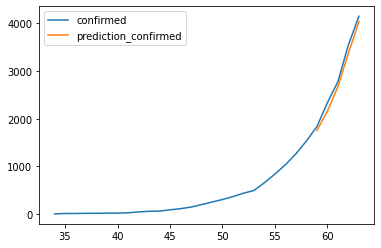

In [6]:
plot_preds(data_pred, 'RU', 'confirmed')

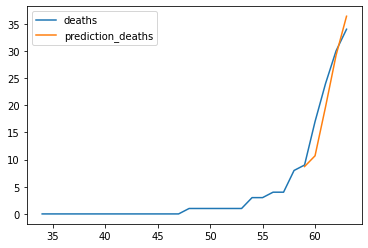

In [7]:
plot_preds(data_pred, 'RU', 'deaths')

# Обучение модели на всем датасете

In [8]:
model_final=CovidModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

runner = SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders={
        "train": DataLoader(CovidDataset(X, y), batch_size=BATCH_SIZE, shuffle=True),
    },
    logdir=LOG_DIR,
    num_epochs=NUM_EPOCHS,
)

# Предсказание

In [9]:
PREDICT_DAYS = 14

def predict_next_day(current_data):
    last_date = current_data['date'].max()
    next_date = last_date + pd.to_timedelta(1, unit='d')

    prev_data = current_data[current_data['date'] == last_date]
    values = []
    for country in prev_data['country']:
        values.append([next_date, country, 0, 0])

    next_data = pd.DataFrame(values, columns=current_data.columns)
    combined_data = current_data.append(next_data)
    next_X = get_X(combined_data)[combined_data['date'] == next_date]

    next_data[['confirmed', 'deaths']] = runner.predict_loader(
        model,
        DataLoader(CovidDataset(next_X), batch_size=BATCH_SIZE, shuffle=False),
    )

    return next_data

def predict(data, num_days=PREDICT_DAYS):
    predict_data = pd.DataFrame(columns=data.columns)
    for i in range(PREDICT_DAYS):
        predict_data = predict_data.append(predict_next_day(data.append(predict_data)))

    return predict_data.rename(columns={
        'confirmed': 'prediction_confirmed',
        'deaths': 'prediction_deaths',
    })

predicts = predict(data)
predicts

,date,country,prediction_confirmed,prediction_deaths
0,2020-04-04,AF,2.515816,0.889698
1,2020-04-04,AL,2.542845,1.289851
2,2020-04-04,DZ,3.151291,2.087609
3,2020-04-04,AD,2.697757,1.279554
4,2020-04-04,AO,1.031170,0.476842
...,...,...,...,...
164,2020-04-17,BF,3.248670,1.718352
165,2020-04-17,UY,3.271667,1.478873
166,2020-04-17,UZ,3.011065,1.112458
167,2020-04-17,VE,3.057297,1.507192


# Визуализация

In [10]:
data_pred = data.append(predicts)

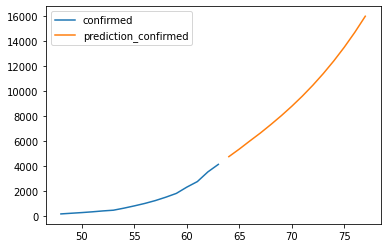

In [11]:
plot_preds(data_pred, 'RU', 'confirmed')

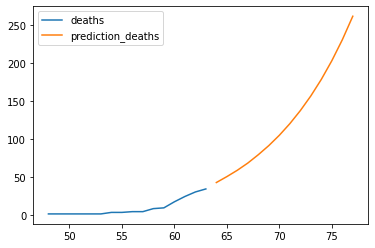

In [12]:
plot_preds(data_pred, 'RU', 'deaths')

# Сохранение

In [13]:
PREDICT_COLUMNS = ['prediction_confirmed', 'prediction_deaths']

df = predicts.copy()
df[PREDICT_COLUMNS] = (10 ** df[PREDICT_COLUMNS] - 1).astype(int)

df.to_csv('data/submission.csv', index=False)